In [1]:
# Libraries
import numpy as np
import mne
from mne_connectivity import spectral_connectivity_time
from mne_connectivity import spectral_connectivity_epochs
import scipy.io
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt

In [2]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

Not setting metadata
1 matching events found


No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.


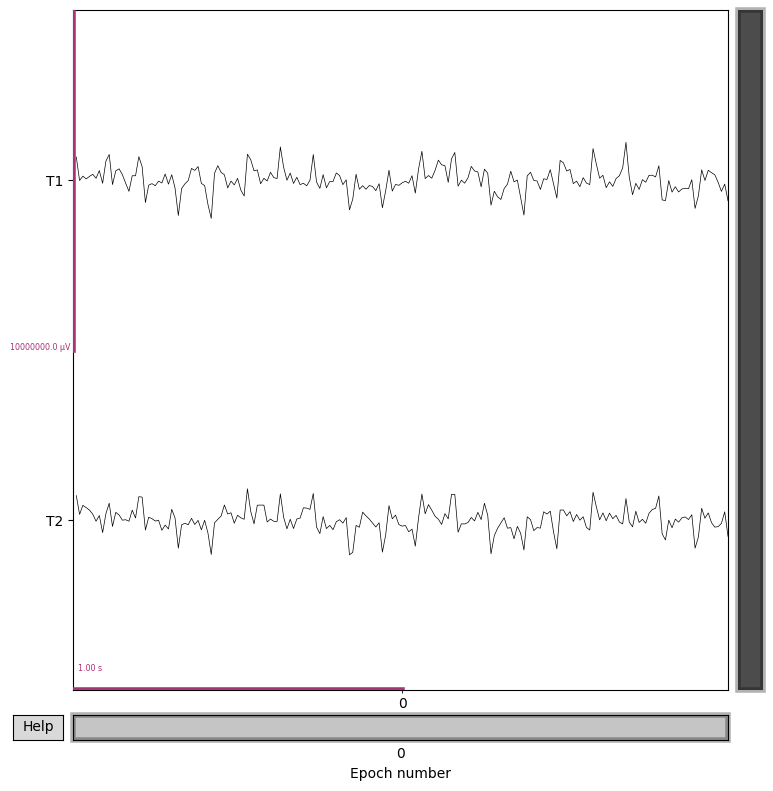

(1, 2, 200)
[ 2.  11.5 21.  30.5 40. ]


In [3]:
# Generate some data
n_epochs = 1
n_channels = 2
n_times = 200
sfreq = 100
t = np.arange(n_times) / sfreq

data_option = 1
np.random.seed(2)
data = np.random.rand(n_epochs, n_channels, n_times)

for i in range(n_epochs):
    for c in range(n_channels):
        wave_freqs = np.linspace(2,40,5)
        # Introduce random phase for each channel
        phase = np.random.rand(1)*2*np.pi
        x = np.zeros(n_times)
        for fSine in wave_freqs:
            # Introduce random component to amplitude
            amp = butter_lowpass_filter(np.random.rand(n_times)*2-1,sfreq/5,sfreq)
            # Generate group of sines
            x += np.sin(2*np.pi*fSine*t+phase/(4*fSine)) + amp
        data[i,c] = x/len(wave_freqs)

# Create epochs object for compatibility
ch_names = ["T1","T2"] # random names
info = mne.create_info(ch_names, sfreq, ch_types="eeg")
data_epoch = mne.EpochsArray(data,info)


# print(data_epoch.get_data().shape)
data_epoch.plot(scalings=5)

scipy.io.savemat('simulated_eeg.mat', {'eeg_data': data_epoch.get_data()})
print(data_epoch.get_data().shape)
print(wave_freqs)

Connectivity computation...
   Processing epoch 1 / 1 ...
[Connectivity computation done]


C:\Users\alire\AppData\Local\Temp\ipykernel_21580\3909659213.py:4: RuntimeWarning: There were no Annotations stored in <EpochsArray | 1 events (all good), 0 – 1.99 s (baseline off), ~9 KiB, data loaded,
 '1': 1>, so metadata was not modified.
  con_time = spectral_connectivity_time(data_epoch,


(1, 128)
['T1', 'T2']


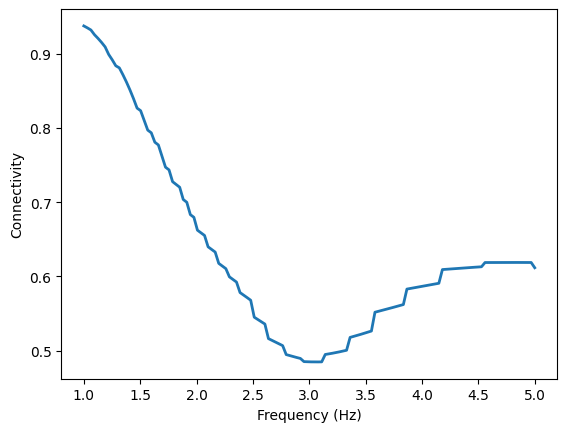

In [4]:
fmin = 1 
fmax = 5
freqs = np.linspace(fmin,fmax, num =128)
con_time = spectral_connectivity_time(data_epoch, 
                                      method="coh",
                                      mode = 'multitaper',
                                      mt_bandwidth =3,
                                      average = True,
                                      sfreq=sfreq,
                                      indices = (np.array([0]),
                                                 np.array([1])),
                                      fmin = 1, 
                                      fmax = 5, 
                                    #   n_cycles=2/freqs,
                                      n_cycles=.5,
                                      freqs=freqs)

# con_time = con_time.get_data()
# # Avg over time
# con_time = np.mean(con_time,axis=-1)
# Avg over epochs
# con_time = np.mean(con_time,axis=0)
# con_time.shape
# Create epochs object for compatibility

print(con_time.get_data().shape)
# print(dir(con_time))
print(con_time.names)
plt.plot(con_time.freqs, np.squeeze(con_time.get_data()[0]), linewidth=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Connectivity")
plt.show()

In [ ]:
conn_lowfreq = spectral_connectivity_time(data = data.crop(tmin = 0, tmax = 0.5), method = 'coh', mode = 'multitaper',
                                        mt_bandwidth = 3, average = True, freqs = np.linspace(1,3, num =250),  # 1024 samples bc Joe’s code’s padding forces us to upsample
                                        fmin = 1, fmax = 3, faverage = False, n_cycles=0.05,
                                        verbose = False, n_jobs = -1)